## Import libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import os
from statistics import stdev
import matplotlib.pyplot as plt




In [4]:
os.chdir(r's:\\Projects\\FlightFarePrediction\\FlightData')
os.getcwd()

's:\\Projects\\FlightFarePrediction\\FlightData'

# Read data


In [5]:
train_data=pd.read_excel('Data_Train.xlsx')
train_data.shape

(10683, 11)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


###### ***Display max columns = none will put no restrictions on display data. i.e. it will show all the columns. if display=2 then 2 columns will be shown***

In [7]:
pd.set_option('display.max_columns',None)

#### Check for the missing values

In [8]:
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [9]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Missing value treatment

##### ***We can see that Route and total_stops vars has missing values so we need to treat them before proceeding***

To get the missing values of Route and Total stops we need to have the info of duration, source and destinations so we will first filter for the source and destination for which the values are missing and then take mode as the missing value imputation. We should consider source and destination here because if we do not filter for the source and destination and calculate the mode of total stops then it can take values of those sources which are not from delhi or cochin but route will depend on the duration and source and destintaions.

In [10]:
train_data[train_data['Route'].isnull()][['Source','Destination']]

,Source,Destination
9039,Delhi,Cochin


In [24]:
#filtering the source and destination
subset=train_data[(train_data['Source']=='Delhi') & (train_data['Destination']=='Cochin')] 

#calculating mode of Route and total stops
Mode_Route=subset['Route'].mode()
Mode_Total_Stops=subset['Total_Stops'].mode()

#fill the null values with mode
train_data['Route']=train_data['Route'].fillna(Mode_Route[0])
train_data['Total_Stops']=train_data['Total_Stops'].fillna(Mode_Total_Stops[0])


In [25]:
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
Journey_day        0
Journey_month      0
Journey_year       0
Dep_hr             0
Dep_min            0
Arrival_hr         0
Arrival_min        0
dtype: int64

## CHECKING FOR OUTLIERS

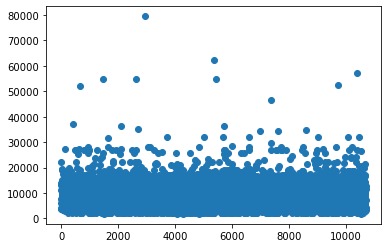

In [12]:
import matplotlib.pyplot as plt
plt.scatter(range(0,len(train_data)),train_data['Price'])

array([[<AxesSubplot:title={'center':'Price'}>]], dtype=object)

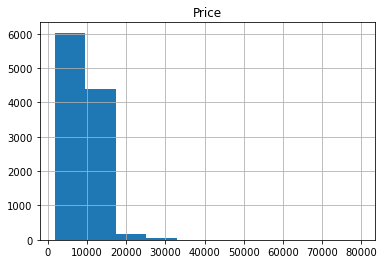

In [13]:
# fig, ax = plt.subplots(figsize =(10, 7))
train_data.hist(column='Price')
# plt.show()

In [14]:
def detectoutliers(df,column):
    mew=df[column].mean()
    sigma=stdev(df[column])

    outlier=[]
    for i in df[column]:
        z= (i-mew)/sigma
        if z>3 or z<3:  #or i>mew+-3sigma 
            outlier.append(i)
    return pd.DataFrame(outlier)

outlier_df=detectoutliers(train_data,'Price')
if outlier_df.shape[0]>0:
    print('outlier is present')



outlier is present


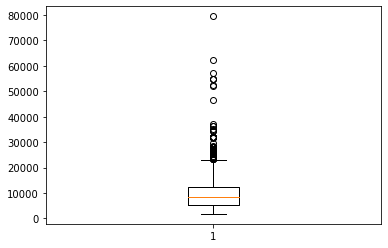

In [15]:
plt.boxplot(train_data['Price'])
plt.show()

We have outliers so we will treat the outliers by capping the data to the value of q1-3*IQR, q3+3*IQR. we will multiply IQR by 3 because we do not want to miss much of the data as the fares are dynamic.  multiplying by 1.5 will remove lot of more data.  We will remove only the extreme values which can effect the pricing of fares very rapidly. Like Business class fares are very high than the usual ones but the % of business class tickets is very less but if we keep the high values of business class then the fares can be wrongly estimated.

In [16]:
train_data[train_data['Additional_Info']=='Business class']


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
2924,Jet Airways Business,01/03/2019,Banglore,New Delhi,BLR → BOM → DEL,05:45,11:25,5h 40m,1 stop,Business class,79512
3032,Jet Airways,01/03/2019,Banglore,New Delhi,BLR → BDQ → DEL,05:50,12:20,6h 30m,1 stop,Business class,28097
5372,Jet Airways Business,01/03/2019,Banglore,New Delhi,BLR → BOM → DEL,05:45,12:25,6h 40m,1 stop,Business class,62427
10364,Jet Airways Business,01/03/2019,Banglore,New Delhi,BLR → MAA → DEL,09:45,14:25,4h 40m,1 stop,Business class,57209


In [17]:
Q1= train_data['Price'].quantile(0.25)
Q2= train_data['Price'].quantile(0.5)
Q3= train_data['Price'].quantile(0.75)
IQR= Q3-Q1
lowbridge= Q1-(3*IQR)
upbridge= Q3+(3*IQR)


def cappedoutliers(df,column):
    for i in df[column]:
        if i>=upbridge:
            df[column]=df[column].replace(i,upbridge)
    return df

train_data_outlier_treated=cappedoutliers(train_data,'Price')




# Sorting the variables



***Converting the date_of_journey to numerical variable from string***

In [18]:
train_data_outlier_treated['Date_of_Journey']=pd.to_datetime(train_data_outlier_treated['Date_of_Journey'],format="%d/%m/%Y")

***separating day and month from date_of_journey column to single numerical variable from date***

In [19]:
train_data_outlier_treated['Journey_day']=pd.to_datetime(train_data_outlier_treated['Date_of_Journey'],format="%d/%m/%Y").dt.day
train_data_outlier_treated['Journey_month']=pd.to_datetime(train_data_outlier_treated['Date_of_Journey'],format="%d/%m/%Y").dt.month
train_data_outlier_treated['Journey_year']=pd.to_datetime(train_data_outlier_treated['Date_of_Journey'],format="%d/%m/%Y").dt.year

In [20]:
train_data_outlier_treated.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,2019
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5,2019


converting departure time to hr and minutes separately in two different columns.
Departure time is when a plane leaves the gate. We can extract this from date_of_journey column also if the date_of_journey column is given the departure time and arrival time

In [21]:
train_data_outlier_treated['Dep_hr']=pd.to_datetime(train_data_outlier_treated.Dep_Time).dt.hour
train_data_outlier_treated['Dep_min']=pd.to_datetime(train_data_outlier_treated.Dep_Time).dt.minute

converting arrival time to hr and minutes separately in two different columns.
arrival time is when a plane leaves the gate. We can extract this from date_of_journey column also if the date_of_journey column is given the departure time and arrival time

In [22]:
train_data_outlier_treated['Arrival_Time']=pd.to_datetime(train_data_outlier_treated.Arrival_Time)

train_data_outlier_treated['Arrival_hr']=pd.to_datetime(train_data_outlier_treated.Arrival_Time).dt.hour
train_data_outlier_treated['Arrival_min']=pd.to_datetime(train_data_outlier_treated.Arrival_Time).dt.minute

# Another Simple way to extract the numbers from string in separate columns.
#(\d+) takes all the numbers before m or h

THIS APPROACH IS MORE SIMPLE AND SAVES TIME AS IT CHECK ALL ROWS OF ALL COLUMNS BUT CHECKS ONLY DURATION COLUMN--ACC TO ME


In [48]:
train_data_duration=train_data_outlier_treated.copy()
train_data_duration['Duration_hour']=train_data_duration['Duration'].str.extract('(\d+)h')
train_data_duration['Duration_minutes']=train_data_duration['Duration'].str.extract('(\d+)m')
train_data_duration['Duration_hour']=train_data_duration['Duration_hour'].fillna(0)
train_data_duration['Duration_minutes']=train_data_duration['Duration_minutes'].fillna(0)


In [49]:
train_data_duration[train_data_duration['Duration'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year,Dep_hr,Dep_min,Arrival_hr,Arrival_min,Duration_hour,Duration_minutes


In [50]:
train_data_duration.Duration_minutes.isnull().sum()

0

# Approach to convert durtation column online. where the cells with onky mins and hrs are converted to strings with both hrs and mins

In [51]:
# duration=list(train_data['Duration'])
# for i in range(len(duration)):
#     if len(duration[i].split())!=2:
#         if 'h' in duration[i]:
#             duration[i]=duration[i] +' 0m'
#         elif 'm' in duration[i]:
#             duration[i]='0h ' + duration[i]
# len(duration)

In [52]:
# ds_hr=[]
# ds_min=[]
# for i in duration:
#     ds_hr.append(i.split('h')[0])
#     ds_min.append(i.split('m')[-1])

############################################################

In [53]:
# train_data.head()

In [54]:
train_data_duration.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Journey_day', 'Journey_month',
       'Journey_year', 'Dep_hr', 'Dep_min', 'Arrival_hr', 'Arrival_min',
       'Duration_hour', 'Duration_minutes'],
      dtype='object')

In [55]:
train_data_duration.Total_Stops.unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [56]:
train_data_duration.Total_Stops.value_counts()

1 stop      5626
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

# Convert total_stops to categorical values

In [57]:
train_data=train_data_duration.copy()
train_data['stops']=train_data['Total_Stops'].replace(['non-stop','1 stop','2 stops','3 stops','4 stops'],[0,1,2,3,4])


In [58]:
# t=train_data[(train_data['Source']=='Delhi') & (train_data['Destination']=='Cochin')]
train_data['stops'].mode()

0    1
dtype: int64

In [59]:
train_data.isnull().sum()

Airline             0
Date_of_Journey     0
Source              0
Destination         0
Route               0
Dep_Time            0
Arrival_Time        0
Duration            0
Total_Stops         0
Additional_Info     0
Price               0
Journey_day         0
Journey_month       0
Journey_year        0
Dep_hr              0
Dep_min             0
Arrival_hr          0
Arrival_min         0
Duration_hour       0
Duration_minutes    0
stops               0
dtype: int64

# For categorical variables:
    
If the variable is nominal then ONEHOTENCODING
If variable is ordinal then LABEL ENCODING

Onehot encoding is to convert the all the vars into variables with 0,1 values

label encoding is to convert all the vars into ranking column whcih wiull have 0,1,2,3,4 like that

In [60]:
train_data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Journey_day', 'Journey_month',
       'Journey_year', 'Dep_hr', 'Dep_min', 'Arrival_hr', 'Arrival_min',
       'Duration_hour', 'Duration_minutes', 'stops'],
      dtype='object')

Categorical analysis. We will plot a category plot using boxplot for each category of each variable to see the distribution of the variables. THIS PART IS NOT NECESSARY. BUT STILL DOING BECAUSE ITS A PART OF EDA.

In [61]:
train_data.Airline.value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [62]:
train_data[train_data['Airline']=='Jet Airways Business']

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year,Dep_hr,Dep_min,Arrival_hr,Arrival_min,Duration_hour,Duration_minutes,stops
657,Jet Airways Business,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,05:45,2022-12-17 10:45:00,5h,1 stop,No info,33661,1,3,2019,5,45,10,45,5,0,1
2924,Jet Airways Business,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,05:45,2022-12-17 11:25:00,5h 40m,1 stop,Business class,33661,1,3,2019,5,45,11,25,5,40,1
5372,Jet Airways Business,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,05:45,2022-12-17 12:25:00,6h 40m,1 stop,Business class,33661,1,3,2019,5,45,12,25,6,40,1
7351,Jet Airways Business,2019-03-03,Delhi,Cochin,DEL → ATQ → BOM → COK,20:05,2022-03-04 04:25:00,8h 20m,2 stops,No info,33661,3,3,2019,20,5,4,25,8,20,2
9715,Jet Airways Business,2019-03-06,Delhi,Cochin,DEL → ATQ → BOM → COK,20:05,2022-03-07 04:25:00,8h 20m,2 stops,No info,33661,6,3,2019,20,5,4,25,8,20,2
10364,Jet Airways Business,2019-03-01,Banglore,New Delhi,BLR → MAA → DEL,09:45,2022-12-17 14:25:00,4h 40m,1 stop,Business class,33661,1,3,2019,9,45,14,25,4,40,1


In [63]:
train_data.isnull().sum()

Airline             0
Date_of_Journey     0
Source              0
Destination         0
Route               0
Dep_Time            0
Arrival_Time        0
Duration            0
Total_Stops         0
Additional_Info     0
Price               0
Journey_day         0
Journey_month       0
Journey_year        0
Dep_hr              0
Dep_min             0
Arrival_hr          0
Arrival_min         0
Duration_hour       0
Duration_minutes    0
stops               0
dtype: int64

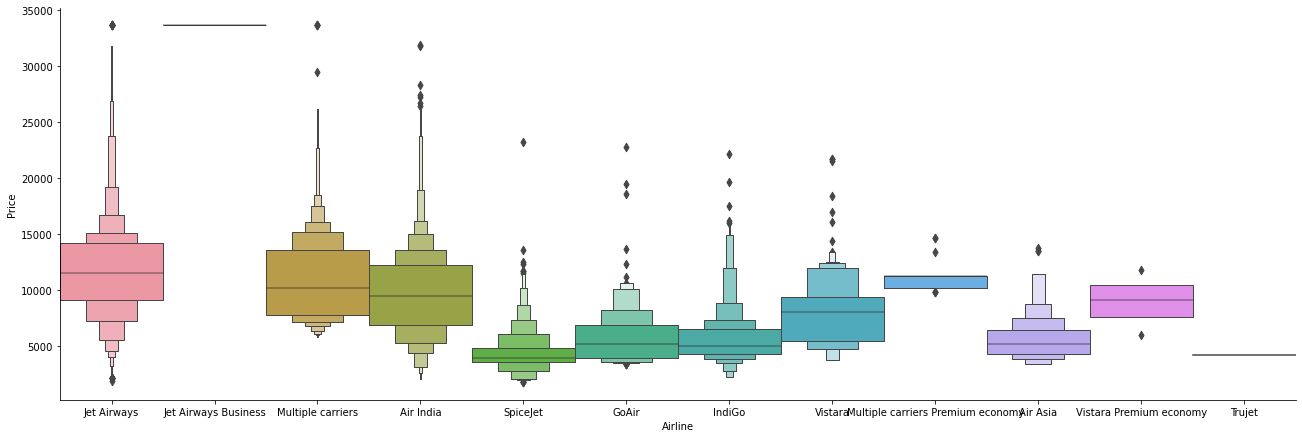

In [64]:
from turtle import width
import seaborn as sns
sns.catplot(x='Airline',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',height=6,width=1,aspect=3)

#Jet airways business class is under jet airways only so merged ut together instead of having different variable

In [65]:
train_data['Airline']=train_data['Airline'].replace(['Jet Airways Business'],['Jet Airways'])
train_data['Airline'].unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Multiple carriers Premium economy',
       'Trujet'], dtype=object)

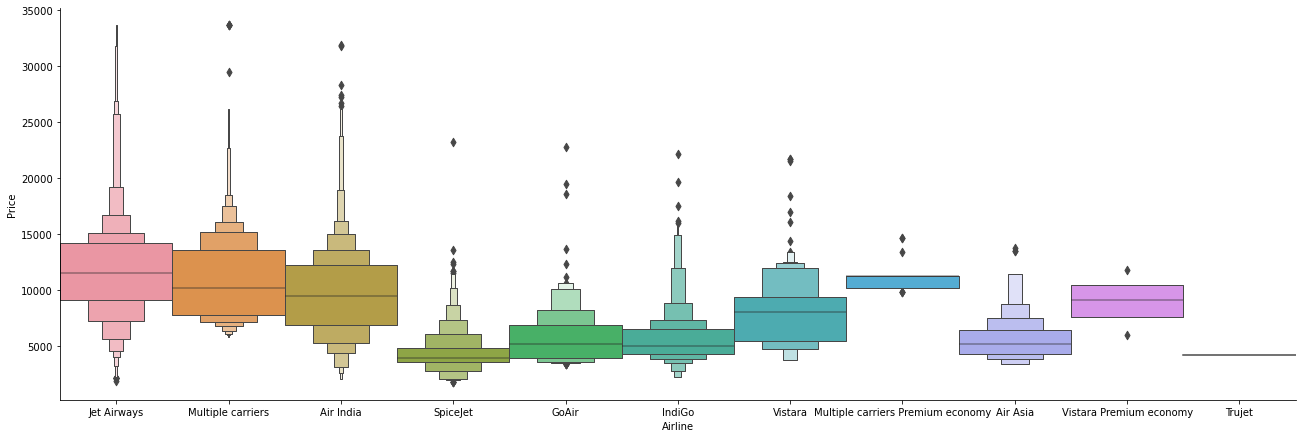

In [66]:
from turtle import width
import seaborn as sns
sns.catplot(x='Airline',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',height=6,width=1,aspect=3)

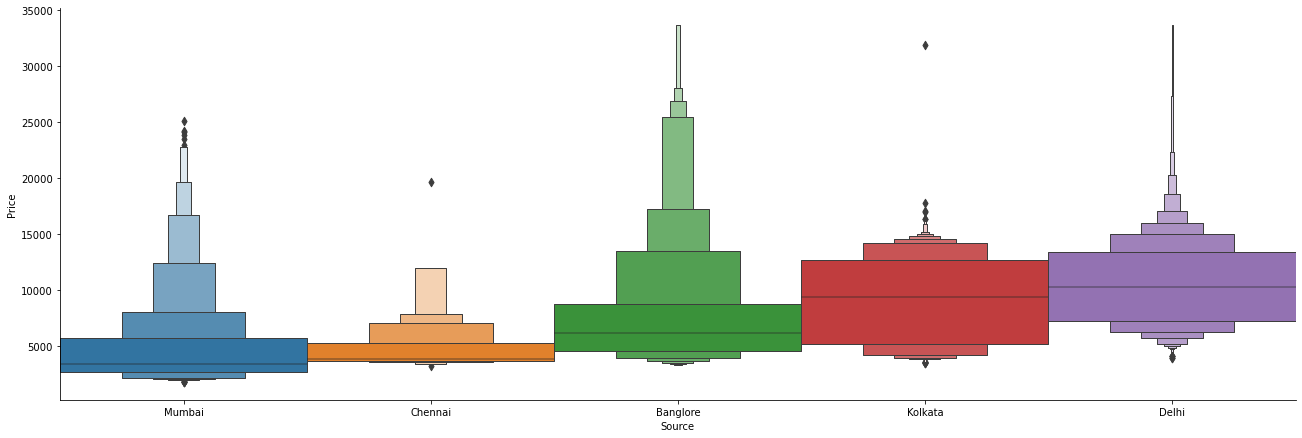

In [67]:
sns.catplot(x='Source',y='Price',data=train_data.sort_values('Price'),kind='boxen',height=6,width=-1,aspect=3)

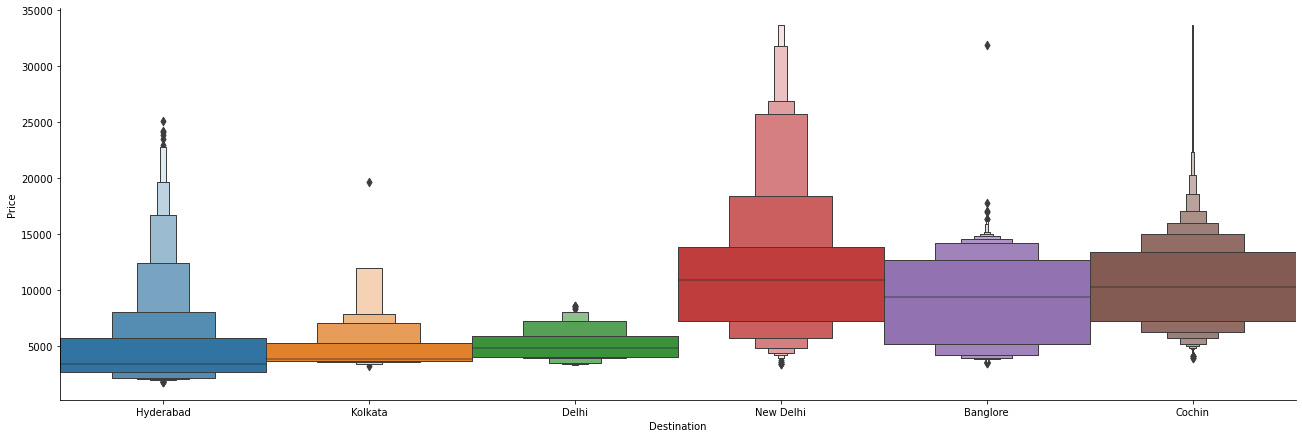

In [68]:
sns.catplot(x='Destination',y='Price',data=train_data.sort_values('Price'),kind='boxen',height=6,width=1,aspect=3)

#Source, airline, destination all the categorical and nominal so we will go with onehotencoding

In [69]:
train_data_initial_cats_names=train_data.copy()
ls_cat_vars=['Airline','Source','Destination']
for i in ls_cat_vars:
    train_data_initial_cats_names[i]=i +'_' +train_data_initial_cats_names[i]


In [70]:
train_data_initial_cats_names.Airline

0             Airline_IndiGo
1          Airline_Air India
2        Airline_Jet Airways
3             Airline_IndiGo
4             Airline_IndiGo
                ...         
10678       Airline_Air Asia
10679      Airline_Air India
10680    Airline_Jet Airways
10681        Airline_Vistara
10682      Airline_Air India
Name: Airline, Length: 10683, dtype: object

In [71]:
from sklearn.preprocessing import OneHotEncoder
encod=OneHotEncoder()
encoded_data=pd.DataFrame(encod.fit_transform(train_data_initial_cats_names[['Airline','Source','Destination']]).toarray())

In [72]:
cats=encod.categories_
cats
labels=np.concatenate(cats)

In [73]:
onehotdata=pd.DataFrame(encoded_data.values.tolist(),columns=labels)

In [74]:
onehotdata

,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10679,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10680,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [75]:
final_train_data=train_data_initial_cats_names.join(onehotdata)

In [76]:
final_train_data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Journey_day', 'Journey_month',
       'Journey_year', 'Dep_hr', 'Dep_min', 'Arrival_hr', 'Arrival_min',
       'Duration_hour', 'Duration_minutes', 'stops', 'Airline_Air Asia',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
       'Source_Mumbai', 'Destination_Banglore', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_New Delhi'],
      dtype='object')

In [77]:
final_train_data.Source.unique()

array(['Source_Banglore', 'Source_Kolkata', 'Source_Delhi',
       'Source_Chennai', 'Source_Mumbai'], dtype=object)

# Another Approach to get dummies or one hot encoding in a much easier way. In This function drop_first=True will create a variable less i.e., 
if we have 5 categories then 4 vars will created with 1,0 and the 5th one will be denoted by 4 zeroes. We are not using drop_first=True here

In [78]:
# dummies=pd.get_dummies(train_data[['Airline','Source','Destination']])

In [79]:
# dummies.head()

In [80]:
# final_train_data_copy2=train_data.join(dummies)

In [81]:
########NEXT steps- feature selection.

# To select the features we need to check the correlation matrix of all features so that we can have an idea of which vars to select. This is exploratory analyisis. So, we will use heatmap here to get the matrix

In [82]:

final_train_data.drop(['Airline','Date_of_Journey','Source','Destination','Route'],axis=1,inplace=True)
final_train_data.drop(['Arrival_Time','Duration','Total_Stops','Additional_Info','Dep_Time'],axis=1,inplace=True)

final_train_data.head()

,Price,Journey_day,Journey_month,Journey_year,Dep_hr,Dep_min,Arrival_hr,Arrival_min,Duration_hour,Duration_minutes,stops,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,3897,24,3,2019,22,20,1,10,2,50,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7662,1,5,2019,5,50,13,15,7,25,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,13882,9,6,2019,9,25,4,25,19,0,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,6218,12,5,2019,18,5,23,30,5,25,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,13302,1,3,2019,16,50,21,35,4,45,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [83]:
final_train_data.isnull().sum()

Price                                        0
Journey_day                                  0
Journey_month                                0
Journey_year                                 0
Dep_hr                                       0
Dep_min                                      0
Arrival_hr                                   0
Arrival_min                                  0
Duration_hour                                0
Duration_minutes                             0
stops                                        0
Airline_Air Asia                             0
Airline_Air India                            0
Airline_GoAir                                0
Airline_IndiGo                               0
Airline_Jet Airways                          0
Airline_Multiple carriers                    0
Airline_Multiple carriers Premium economy    0
Airline_SpiceJet                             0
Airline_Trujet                               0
Airline_Vistara                              0
Airline_Vista

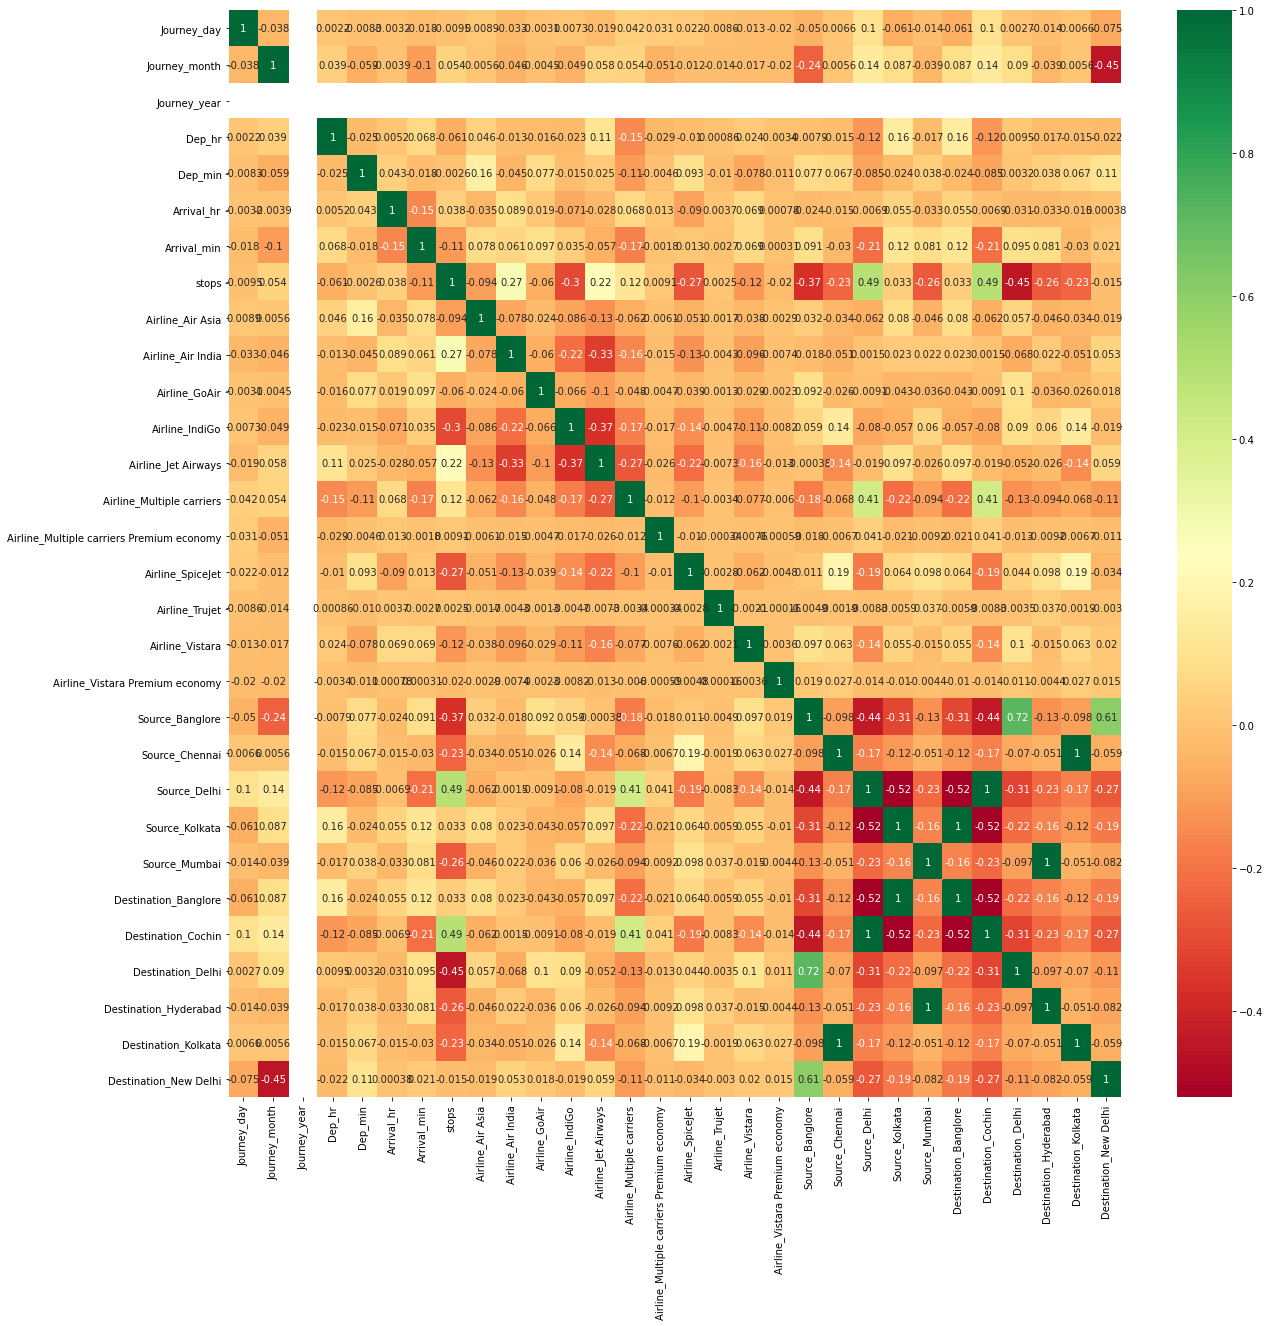

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,20))
final_train_data_1= final_train_data.drop(['Price'],axis=1)
sns.heatmap(final_train_data_1.corr(),annot=True,cmap="RdYlGn")
plt.show()

In [85]:
X=final_train_data_1
y=final_train_data['Price']

In [86]:
X.isnull().sum()

Journey_day                                  0
Journey_month                                0
Journey_year                                 0
Dep_hr                                       0
Dep_min                                      0
Arrival_hr                                   0
Arrival_min                                  0
Duration_hour                                0
Duration_minutes                             0
stops                                        0
Airline_Air Asia                             0
Airline_Air India                            0
Airline_GoAir                                0
Airline_IndiGo                               0
Airline_Jet Airways                          0
Airline_Multiple carriers                    0
Airline_Multiple carriers Premium economy    0
Airline_SpiceJet                             0
Airline_Trujet                               0
Airline_Vistara                              0
Airline_Vistara Premium economy              0
Source_Banglo

To select the features we will use extra tree regressor here. Extra tree regressor is a method to select important features where it selects those features which has top ginis index or entropy. It shows and ranks the features based on its ginis index and impurity.

In [87]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
extratree= ExtraTreesClassifier()
extratree.fit(X,y)

ExtraTreesClassifier()

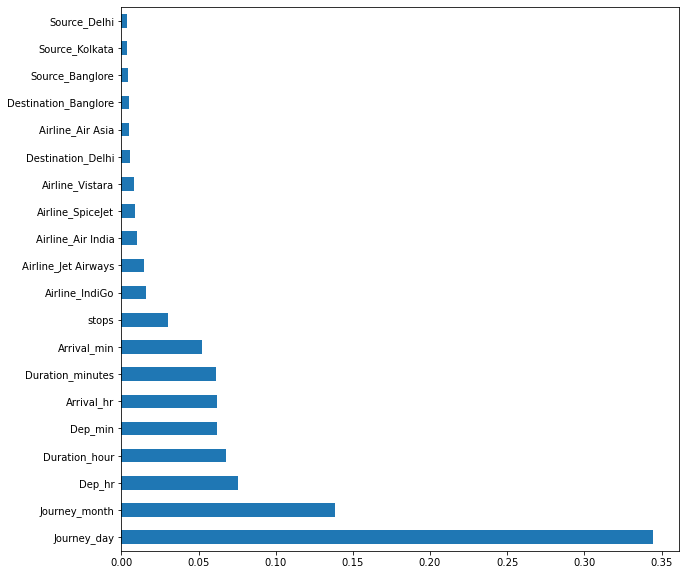

In [88]:

feature_importance=extratree.feature_importances_
selected_features=pd.Series(feature_importance,index=X.columns)
plt.figure(figsize=(10,10))
selected_features.nlargest(20).plot(kind='barh')
plt.show()

#try for all algorithms-lr,ridge,lasso, polynomial, rf---ridge lasso because the price is dependent and it continuos. 
logistic cant be applied because we dependent is not categorical


In [89]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=2)


#We will try different models andf check the accuracy and choose the one which has highest accuracy

#Multiple Linear regression

In [90]:

from sklearn import linear_model
linearmodel=linear_model.LinearRegression()
linearmodel.fit(X_train,y_train)


LinearRegression()

In [91]:
linearmodel.score(X_train,y_train)

0.607239180694806

In [92]:
linearmodel.score(X_test,y_test)

0.6081533211290252

In [93]:
y_train_pred=linearmodel.predict(X_train)
y_test_pred=linearmodel.predict(X_test)

In [94]:
from sklearn import metrics
from math import sqrt
mse=metrics.mean_squared_error(y_train,y_train_pred)
# accuracy=metrics.score(y_train,y_train_pred)
print(mse)
print(sqrt(mse))

7706754.276387788
2776.1041544559866


In [95]:
from sklearn import metrics
r2_score=metrics.r2_score(y_train,y_train_pred)
r2_score

0.607239180694806

In [96]:
from sklearn import metrics
score=linearmodel.score(X_train,y_train)
score

0.607239180694806

## RIDGE REGRESSION


Using gridsearchcv at first because want to have the best tuned optimal parameters to create ridge regression. Using Gridsearch because Gridsearch uses all possible values that we pass and randomsearchcv uses randomly till n_iter. so having grid we will consider all the values so that we can have best model

In [97]:
from sklearn import model_selection
from sklearn import linear_model
from numpy import arange
from sklearn.model_selection import RepeatedKFold
cv=RepeatedKFold(n_splits=5,n_repeats=10,random_state=0)
grid=dict()
grid['alpha'] = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
grid
ridge_regression=model_selection.GridSearchCV(linear_model.Ridge(),grid,cv=5,scoring='neg_mean_absolute_error',n_jobs=-1)
ridge_model=ridge_regression.fit(X_train,y_train)


In [98]:
print('Best alpha to use:',ridge_model.best_params_)

Best alpha to use: {'alpha': 10}


In [99]:
cv=pd.DataFrame(ridge_model.cv_results_)
cv.to_csv('cv.csv',index=False)

In [100]:
ridge_regression_withbest_alpha=linear_model.Ridge(alpha=10)
ridge_regression_bestalpha=ridge_regression_withbest_alpha.fit(X_train,y_train)


In [101]:

print('train set score:', ridge_regression_bestalpha.score(X_train,y_train))
print('test set score:', ridge_regression_bestalpha.score(X_test,y_test))

train set score: 0.6071097342550473
test set score: 0.6083071244654359


In [102]:
ridge_regression_bestalpha.score(X_train,y_train)

0.6071097342550473

In [103]:
from sklearn.metrics import r2_score
y_train_pred=ridge_regression_bestalpha.predict(X_train)
r2_score(y_train,y_train_pred)

0.6071097342550473

In [104]:
# # cv=RepeatedKFold(n_splits=5,n_repeats=10,random_state=0)
# grid=dict()
# grid = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
# # print(grid)
# for i in grid:
#     # print(i)
#     ridge_regression=linear_model.Ridge(alpha=i)
#     ridge_model=ridge_regression.fit(X_train,y_train)
#     print('score:',ridge_model.score(X_train,y_train))
#     print('parameter:',i)
    


In [105]:

ridge_reg=linear_model.Ridge()
ridge_m=ridge_reg.fit(X_train,y_train)

In [106]:

ridge_reg1=linear_model.Ridge(alpha=10)
ridge_m1=ridge_reg1.fit(X_train,y_train)

In [107]:
ridge_m1.score(X_train,y_train)

0.6071097342550473

In [108]:
ridge_m.score(X_train,y_train)

0.6072345750211154

## Lasso

In [89]:
from sklearn import model_selection
from sklearn import linear_model
from numpy import arange
from sklearn.model_selection import RepeatedKFold
cv=RepeatedKFold(n_splits=5,n_repeats=10,random_state=0)
grid=dict()
grid['alpha'] = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
grid
Lasso_regression=model_selection.GridSearchCV(linear_model.Lasso(),grid,cv=5,scoring='neg_mean_absolute_error',n_jobs=-1)
Lasso_model=ridge_regression.fit(X_train,y_train)


In [90]:
Lasso_model.best_params_

{'alpha': 10}

In [91]:

lasso_reg1=linear_model.Lasso(alpha=10)
lasso_m1=lasso_reg1.fit(X_train,y_train)
lasso_m1.score(X_train,y_train)

0.6055934299726295

In [92]:
y_train_pred=lasso_m1.predict(X_train)
r2_score(y_train,y_train_pred)

0.6055934299726295

## Random Forest

Applying regressor because the target variable is continuos

In [147]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor= RandomForestRegressor()
rf_regressor.fit(X_train,y_train)


RandomForestRegressor()

In [149]:
y_train_pred_rf=rf_regressor.predict(X_train)

In [150]:
rf_regressor.score(X_test,y_test)

0.8227111668493668

In [151]:
y_pred=rf_regressor.predict(X_test)
errors=y_test-y_pred

c:\Users\soumi\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


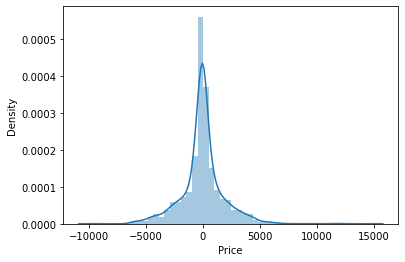

In [152]:
sns.distplot(errors)
plt.show()

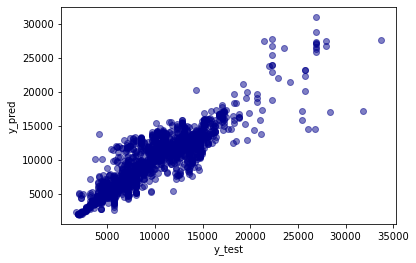

In [154]:
plt.scatter(y_test,y_pred,alpha=0.5,color='DarkBlue')
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

### Hyperparameter Tuning

In [135]:
import numpy as np
n_estimators=np.arange(100,1100,100).tolist()
min_samples_split=np.arange(2,20,1).tolist()
min_samples_leaf=np.arange(1,50,2).tolist()
max_features=[0.5,1,"sqrt","auto"]
max_depth=np.arange(5,31,5).tolist()
rf_parameters={'n_estimators':n_estimators,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf,
            'max_features':max_features,
            'max_depth':max_depth}



In [136]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold

r=model_selection.RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,random_state=42),param_distributions=rf_parameters,cv=5,verbose=2)
r.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=37, max_features=1, max_depth=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=37, max_features=1, max_depth=5, total=   4.1s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=37, max_features=1, max_depth=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=37, max_features=1, max_depth=5, total=   1.3s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=37, max_features=1, max_depth=5 
[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=37, max_features=1, max_depth=5, total=   1.3s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=37, max_features=1, max_depth=5 
[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=37, max_features=1, max_depth=5, total=   1.4s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=37, max_features=1, max_depth=5 
[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=37, max_features=1, max_depth=5, total=   1.3s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=19, max_features=1, max_depth=20 
[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=19, max_features=1, max_depth=20, total=   1.4s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=19, max_features

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   59.8s finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13, 15, 17, 19, 21,
                                                             23, 25, 27, 29, 31,
                                                             33, 35, 37, 39, 41,
                                                             43, 45, 47, 49],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                       

In [158]:
r.best_params_

{'n_estimators': 400,
 'min_samples_split': 18,
 'min_samples_leaf': 23,
 'max_features': 'auto',
 'max_depth': 30}

In [159]:
# r.predict(X_test)
y_test_pred=r.predict(X_test)
r2_score(y_test,y_test_pred)

0.7913931535941562

In [160]:
y_pred=r.predict(X_test)
errors=y_test-y_pred

c:\Users\soumi\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


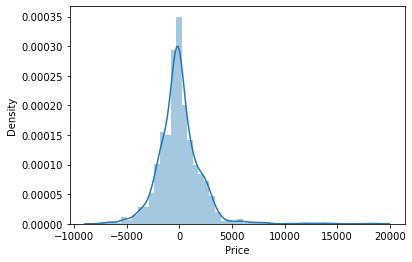

In [161]:
import seaborn as sns
sns.distplot(errors)
plt.show()

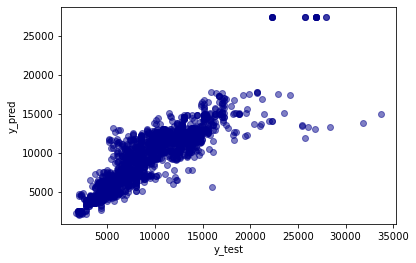

In [163]:
plt.scatter(y_test,y_pred,alpha=0.5,color='DarkBlue')
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [165]:
open("flight_rf.pkl","wb")

<_io.BufferedWriter name='flight_rf.pkl'>